## <span style="color:RoyalBlue">Predicting Churn for Termfront</span>
#### <span style="color:Navy">Author: Jessica Marx</span>

### Purpose
A hypothetical company, Termfront, has created a document editing platform that is an enterprise software solution for creating high-quality writing, based on a web-based word processor. Under their business model, companies can purchase a monthly subscription that enables everyone at that company to use Termfront’s platform for a given month.

The Termfront team hopes to understand what factors predict churn, so they can identify at-risk accounts early and intervene. The hypothesis is that usage of their platform might relate to risk of account churn.

- `Null Hypothesis:` Termfront platform usage `does not` cause churn
- `Alternative:` Termfront platform usage `does` cause churn

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from datetime import datetime, timedelta, date
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance

pd.options.display.max_columns = None

In [2]:
events_df = pd.read_csv('termfront_document_edit_events2.csv')
accounts_df = pd.read_csv('account_churn.csv')

In [3]:
no_chrnd = len(accounts_df[accounts_df['churned'] == True])
pct_chrnd = no_chrnd/len(accounts_df)*100.00
print(f"During this time period, {no_chrnd} accounts churned ({pct_chrnd}%).")

During this time period, 14 accounts churned (20.0%).


In [4]:
events_df['event_time'] = pd.to_datetime(events_df['event_time'])
events_df['date'] = [datetime.date(d) for d in events_df['event_time']] 
events_df['date'] = pd.to_datetime(events_df['date'])

In [5]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80564 entries, 0 to 80563
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   request_id          80564 non-null  object             
 1   account_id          80564 non-null  int64              
 2   user_id             80564 non-null  object             
 3   hasTyped            80564 non-null  bool               
 4   titleWordCount      80564 non-null  int64              
 5   bodyWordCountStart  80564 non-null  int64              
 6   bodyWordCountEnd    80564 non-null  int64              
 7   documentId          80564 non-null  object             
 8   browser             80564 non-null  object             
 9   device_platform     80564 non-null  object             
 10  event_time          80564 non-null  datetime64[ns, UTC]
 11  editNumber          80564 non-null  int64              
 12  date                80564 non-nu

In [6]:
# are all accounts in both tables? no
print(f"Accounts in Events Table: {len(events_df['account_id'].unique())}")
print(f"Accounts in Accounts Table: {len(accounts_df['account_id'].unique())}")

Accounts in Events Table: 66
Accounts in Accounts Table: 70


In [7]:
# accounts that never show up in events table 
no_events_accts = list(set(accounts_df['account_id'].unique()) - set(events_df['account_id'].unique()))
print("Accounts that never used the document editing software:")
accounts_df[accounts_df['account_id'].isin(no_events_accts)]

Accounts that never used the document editing software:


account_id  churned           company_name
66          67     True       Duck & Bird, Inc
67          68     True      Acme Dog Products
68          69    False            MeWelco LLC
69          70     True  Widget Stuff & Things

In [8]:
events_df.head()

request_id  account_id  \
0  3a95df7bf8722a50bc0afc61475f48e1           1   
1  e16fda5192d579af8d0979a0897f4c04           2   
2  f155153b01d7fc37e5431bf0b7845d26           3   
3  8d1b87fb9536277c0ae9d7fc526abb16           4   
4  f7d1af9f17846f48973c9dd378f18d28           2   

                            user_id  hasTyped  titleWordCount  \
0  cba250488677a90d7aac59003c413c06      True               3   
1  965c7d7c6701aec84e904e6551a3ed3a      True               9   
2  cd39b693297ef3348f921cfc46ff42bc     False               9   
3  b8e026e6dbeac410f01989231a5c6f01      True               5   
4  52d5bef467d88e36b54c048c2b7eef14      True               5   

   bodyWordCountStart  bodyWordCountEnd                        documentId  \
0                 364               355  4cf9f88a69456136e94a6c807da9e005   
1                 775               775  a1b70b8f39757bc21c1830031ad1a329   
2                1195              1195  2a97629db1f823cd8019c81fbba3465f   
3                 441               441  ea996481ac9ba3d20bcb6d64e2a2963e   
4                 751               752  2ef74f4e1356149c459566f5f930938a   

   browser device_platform                       event_time  editNumber  \
0   Chrome           Win32 2020-10-03 07:28:22.692481+00:00          67   
1   Chrome           Win32 2020-10-03 14:10:42.991536+00:00          22   
2   Chrome        MacIntel 2020-10-02 04:48:11.022041+00:00          31   
3  Firefox        MacIntel 2020-10-26 07:43:22.778347+00:00          50   
4   Chrome           Win32 2020-10-02 04:22:01.081165+00:00          38   

        date  
0 2020-10-03  
1 2020-10-03  
2 2020-10-02  
3 2020-10-26  
4 2020-10-02

In [9]:
# merge dataframes and create some basic features
df_both = accounts_df.merge(events_df, on='account_id', how='left')
df_both['words_added'] = df_both['bodyWordCountStart'] - df_both['bodyWordCountEnd']
df_both['word_count_change'] = np.abs(df_both['bodyWordCountStart'] - df_both['bodyWordCountEnd'])
df_both['hasTyped'] = np.where(df_both['hasTyped'] == True, 1, 0)
# flag for when a new document is created and its first edit
df_both['new_doc'] = df_both.groupby(['account_id','documentId']).cumcount()+1
df_both['new_doc'] = np.where(df_both['new_doc'] == 1, 1, 0)
df_both['new_doc'] = np.where((df_both['new_doc'] == 1) & (df_both['editNumber'] == 1), 1, 0)
df_both.tail(5)

account_id  churned           company_name  \
80563          66    False            O'Keefe Ltd   
80564          67     True       Duck & Bird, Inc   
80565          68     True      Acme Dog Products   
80566          69    False            MeWelco LLC   
80567          70     True  Widget Stuff & Things   

                             request_id                           user_id  \
80563  e5e7d1ae3914ccceffd611d5ac0bfe20  72883766d60b8a5021fcc0372f39c6e5   
80564                               NaN                               NaN   
80565                               NaN                               NaN   
80566                               NaN                               NaN   
80567                               NaN                               NaN   

       hasTyped  titleWordCount  bodyWordCountStart  bodyWordCountEnd  \
80563         0             6.0                 0.0             272.0   
80564         0             NaN                 NaN               NaN   
80565         0             NaN                 NaN               NaN   
80566         0             NaN                 NaN               NaN   
80567         0             NaN                 NaN               NaN   

                             documentId browser device_platform  \
80563  d9760dad0371dbbb84d879036aa612ff  Chrome        MacIntel   
80564                               NaN     NaN             NaN   
80565                               NaN     NaN             NaN   
80566                               NaN     NaN             NaN   
80567                               NaN     NaN             NaN   

                            event_time  editNumber       date  words_added  \
80563 2020-10-01 16:55:05.846912+00:00         2.0 2020-10-01       -272.0   
80564                              NaT         NaN        NaT          NaN   
80565                              NaT         NaN        NaT          NaN   
80566                              NaT         NaN        NaT          NaN   
80567                              NaT         NaN        NaT          NaN   

       word_count_change  new_doc  
80563              272.0        0  
80564                NaN        0  
80565                NaN        0  
80566                NaN        0  
80567                NaN        0

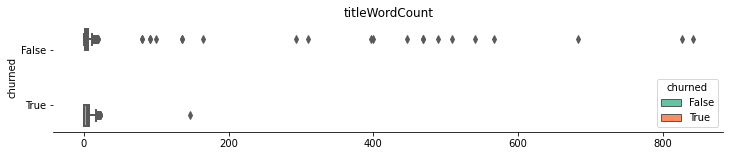

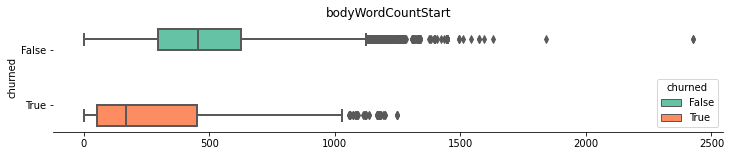

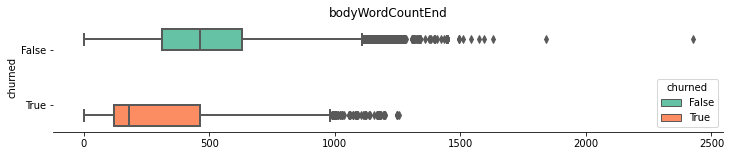

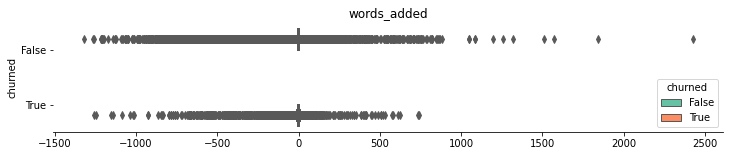

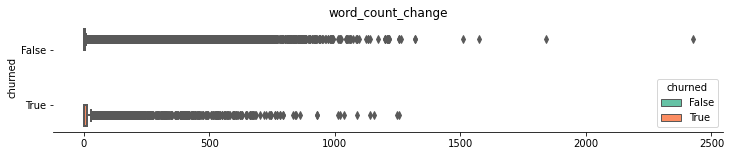

In [10]:
num_cols = df_both.select_dtypes(include=np.number).columns.tolist()
feature_cols = num_cols.copy()
feature_cols = [e for e in feature_cols if e not in ('account_id', 'editNumber', 'hasTyped', 'new_doc')]

for col in range(len(feature_cols)):
    plt.figure(figsize=(12, 2))
    axes = sns.boxplot(data = df_both, x = f"{feature_cols[col]}", y = 'churned'
                       , hue='churned', saturation=1, palette='Set2'
                       , linewidth=2, fliersize=5, orient='h')
    plt.ticklabel_format(style='plain', axis='x')
    plt.title(f"{feature_cols[col]}")
    axes.set_xlabel('', fontsize = 12, fontweight = 'semibold')
    sns.despine(left = True)
    plt.show()

In [11]:
df_acct_agg = df_both.groupby(['account_id', 'company_name', 'churned']).agg(
    n_users=pd.NamedAgg(column='user_id', aggfunc='nunique') 
    , n_requests=pd.NamedAgg(column='request_id', aggfunc='count')
    , n_use_days=pd.NamedAgg(column='date', aggfunc='nunique')
    , n_docs=pd.NamedAgg(column='documentId', aggfunc='nunique')
    , words_changed=pd.NamedAgg(column='word_count_change', aggfunc='sum')
    , min_words=pd.NamedAgg(column='bodyWordCountEnd', aggfunc='min')
    , max_words=pd.NamedAgg(column='bodyWordCountEnd', aggfunc='max')
    , max_edits=pd.NamedAgg(column='editNumber', aggfunc='max')
    , med_edits=pd.NamedAgg(column='editNumber', aggfunc='median')
    , med_title_words=pd.NamedAgg(column='titleWordCount', aggfunc='median')
    , new_docs=pd.NamedAgg(column='new_doc', aggfunc='sum')
).reset_index()

df_acct_agg['docs_per_user'] = df_acct_agg['n_docs']/df_acct_agg['n_users']
df_acct_agg['docs_per_day'] = df_acct_agg['n_docs']/df_acct_agg['n_use_days']
df_acct_agg['requests_per_user'] = df_acct_agg['n_requests']/df_acct_agg['n_users']
df_acct_agg = df_acct_agg.fillna(0)

In [12]:
df_acct_agg.tail()

account_id           company_name  churned  n_users  n_requests  \
65          66            O'Keefe Ltd    False        1          31   
66          67       Duck & Bird, Inc     True        0           0   
67          68      Acme Dog Products     True        0           0   
68          69            MeWelco LLC    False        0           0   
69          70  Widget Stuff & Things     True        0           0   

    n_use_days  n_docs  words_changed  min_words  max_words  max_edits  \
65           1      15         2831.0        0.0      274.0        4.0   
66           0       0            0.0        0.0        0.0        0.0   
67           0       0            0.0        0.0        0.0        0.0   
68           0       0            0.0        0.0        0.0        0.0   
69           0       0            0.0        0.0        0.0        0.0   

    med_edits  med_title_words  new_docs  docs_per_user  docs_per_day  \
65        2.0              7.0         9           15.0          15.0   
66        0.0              0.0         0            0.0           0.0   
67        0.0              0.0         0            0.0           0.0   
68        0.0              0.0         0            0.0           0.0   
69        0.0              0.0         0            0.0           0.0   

    requests_per_user  
65               31.0  
66                0.0  
67                0.0  
68                0.0  
69                0.0

In [13]:
num_cols = df_acct_agg.select_dtypes(include=np.number).columns.tolist()
print(num_cols)

['account_id', 'n_users', 'n_requests', 'n_use_days', 'n_docs', 'words_changed', 'min_words', 'max_words', 'max_edits', 'med_edits', 'med_title_words', 'new_docs', 'docs_per_user', 'docs_per_day', 'requests_per_user']


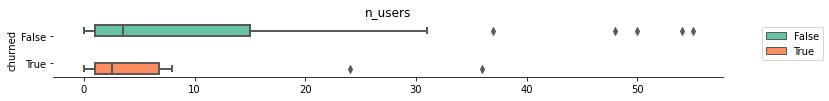

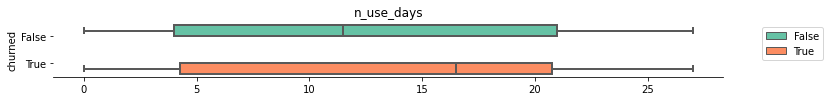

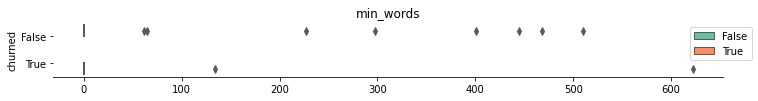

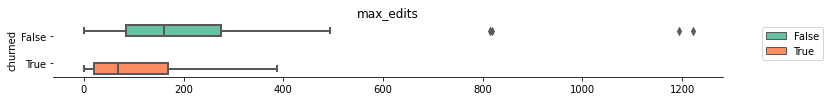

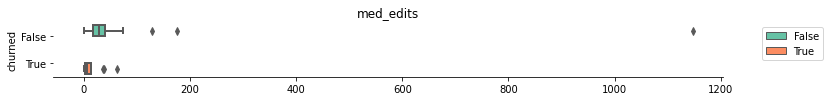

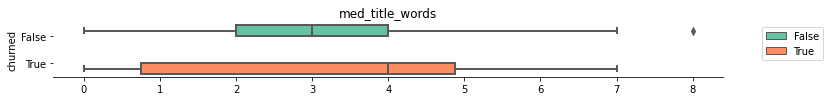

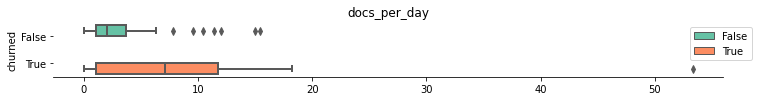

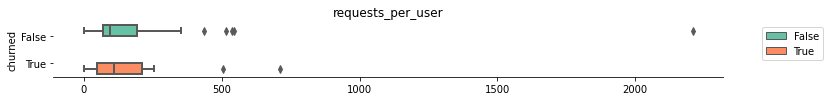

In [14]:
feature_cols = num_cols.copy()
feature_cols = [e for e in feature_cols if e not in ('account_id')]

for col in range(len(feature_cols)):
    plt.figure(figsize=(12, 1))
    axes = sns.boxplot(data = df_acct_agg, x = f"{feature_cols[col]}", y = 'churned'
                       , hue='churned', saturation=1, palette='Set2'
                       , linewidth=2, fliersize=5, orient='h')
    plt.ticklabel_format(style='plain', axis='x')
    plt.title(f"{feature_cols[col]}")
    axes.set_xlabel('', fontsize = 12, fontweight = 'semibold')
    sns.despine(left = True)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

In [15]:
# split the data into 2 groups as if we were looking at matches pairs
df_churned = df_acct_agg[df_acct_agg['churned']==True]
df_no_churn = df_acct_agg[df_acct_agg['churned']==False]

from math import * 
# compare features distributions of treated vs. matched audiences 
def compare_feature_distributions(features, true_group, false_group, unscale = True, columns = 6): 
    
    # if features were log scaled previously and need to be unscaled: 
    if unscale == True: 
        true_group = np.exp(true_group)-1
        false_group = np.exp(false_group)-1 
    
    # plot formatting
    ncols = columns
    nrows = math.ceil((len(features))/ncols)
    width = 14
    height = 2.5*nrows
    fig, axs = plt.subplots(nrows, ncols, figsize = [width, height])
    axs = axs.ravel()
    
    i = 0
    for f in features: 
        axs[i].hist(true_group[f], log = True, color = 'orange', alpha=0.6, label='True')
        axs[i].hist(false_group[f], log = True, color = 'c', alpha=0.6, label='False')
        axs[i].axvline(true_group[f].mean(), color='k', linestyle='dashed', linewidth=1)
        axs[i].axvline(false_group[f].mean(), color='k', linestyle='dashed', linewidth=1)
        axs[i].set_title(f)
        i = i + 1
    fig.suptitle('Churned True vs. False Feature Distributions (Churned in Yellow)', fontsize = 14)
    fig.legend(labels=('Churned','No Churn'))
    plt.subplots_adjust(hspace=0.5)
    plt.show() 

In [16]:
compare_feature_distributions(features=feature_cols, true_group=df_churned, false_group=df_no_churn, unscale=False)

In [17]:
# time series views with cumulative metrics: level is churned + date
df_date = df_both.groupby(['churned', 'date']).agg(
    n_users=pd.NamedAgg(column='user_id', aggfunc='nunique') 
    , n_requests=pd.NamedAgg(column='request_id', aggfunc='count')
    , n_use_days=pd.NamedAgg(column='date', aggfunc='nunique')
    , n_docs=pd.NamedAgg(column='documentId', aggfunc='nunique')
    , words_changed=pd.NamedAgg(column='word_count_change', aggfunc='sum')
    , new_doc=pd.NamedAgg(column='new_doc', aggfunc='sum')
).reset_index()

df_date['Cumsum'] = df_date.groupby(by=['churned'])['n_requests'].cumsum()
df_date['n_accts'] = np.where(df_date['churned']==True, len(accounts_df[accounts_df['churned']==True]), len(accounts_df[accounts_df['churned']==False]))
df_date['cum_new_docs'] = df_date.groupby(by=['churned'])['new_doc'].cumsum()
df_date['activity_per_acct_cum'] = df_date['Cumsum']/df_date['n_accts']
df_date['new_docs_per_acct'] = df_date['cum_new_docs']/df_date['n_accts']

plt.figure(figsize=(10, 8))
sns.lineplot(data=df_date, x='date', y='activity_per_acct_cum', hue='churned',linewidth=3, palette='Set2')
sns.despine(left=True)
plt.xlabel('Event Date', fontweight='semibold', size=12)
plt.ylabel('Running Total of Request Events', fontweight='semibold', size=12)
plt.title('Mean Activity per Account', fontweight='semibold', size=13)
plt.show()

In [18]:
plt.figure(figsize=(10, 8))
sns.lineplot(data=df_date, x='date', y='new_docs_per_acct', hue='churned',linewidth=3, palette='Set2')
sns.despine(left=True)
plt.xlabel('Event Date', fontweight='semibold', size=12)
plt.ylabel('Running Total of New Documents', fontweight='semibold', size=12)
plt.title('Mean New Documents per Account', fontweight='semibold', size=13)
plt.show()

In [19]:
# sample from both groups; this dataframe is at the account + day level
df_cos = df_both.copy()
# df_cos = df_both[df_both['company_name'] != 'Maggio, Wolff and Swift'] # removing because it's skewing the data
df_cos = df_cos.groupby(['churned', 'date', 'company_name']).agg(
    n_users=pd.NamedAgg(column='user_id', aggfunc='nunique') 
    , n_requests=pd.NamedAgg(column='request_id', aggfunc='count')
    , n_use_days=pd.NamedAgg(column='date', aggfunc='nunique')
    , n_docs=pd.NamedAgg(column='documentId', aggfunc='nunique')
    , words_changed=pd.NamedAgg(column='word_count_change', aggfunc='sum')
    , new_doc=pd.NamedAgg(column='new_doc', aggfunc='sum')
).reset_index()

df_cos['cum_new_activity'] = df_cos.groupby(by=['churned', 'company_name'])['n_requests'].cumsum()
df_cos['cum_new_docs'] = df_cos.groupby(by=['churned', 'company_name'])['new_doc'].cumsum()
df_cos['cum_docs'] = df_cos.groupby(by=['churned', 'company_name'])['n_docs'].cumsum()
df_cos['cum_word_change'] = df_cos.groupby(by=['churned', 'company_name'])['words_changed'].cumsum()
print(len(df_cos))
df_cos.sort_values(by=['company_name', 'date']).head()

842


churned       date         company_name  n_users  n_requests  n_use_days  \
677     True 2020-10-05  Ankunding-Considine        1          83           1   
684     True 2020-10-06  Ankunding-Considine        2          45           1   
692     True 2020-10-07  Ankunding-Considine        2          42           1   
702     True 2020-10-08  Ankunding-Considine        3          80           1   
712     True 2020-10-09  Ankunding-Considine        2          88           1   

     n_docs  words_changed  new_doc  cum_new_activity  cum_new_docs  cum_docs  \
677       6         1026.0        2                83             2         6   
684       4         1880.0        1               128             3        10   
692       5         1982.0        1               170             4        15   
702       6         2455.0        3               250             7        21   
712       3         3348.0        2               338             9        24   

     cum_word_change  
677           1026.0  
684           2906.0  
692           4888.0  
702           7343.0  
712          10691.0

In [20]:
# np.random.seed(123)
size = 10 # sample size
replace = False  # with/without replacement 
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
sub_groups = df_cos.groupby(['churned', 'company_name'], as_index=False)['n_users'].count()
sample_cos = sub_groups.groupby('churned', as_index=False).apply(fn)
df_sample = df_cos[df_cos['company_name'].isin(sample_cos['company_name'].unique())].reset_index(drop=True)
print(len(df_sample))

plt.figure(figsize=(10, 8))
sns.lineplot(data=df_sample, x='date', y='cum_new_docs', hue = 'company_name', style='churned', linewidth=2)
sns.despine(left=True)
plt.xlabel('Event Date', fontweight='semibold', size=12)
plt.ylabel('Running Total of New Documents', fontweight='semibold', size=12)
plt.title(f'New Documents by Account (Sample of {size} for each class)', fontweight='semibold', size=13)
plt.legend(bbox_to_anchor=(1.05, 1), fontsize=10)
plt.show()

336


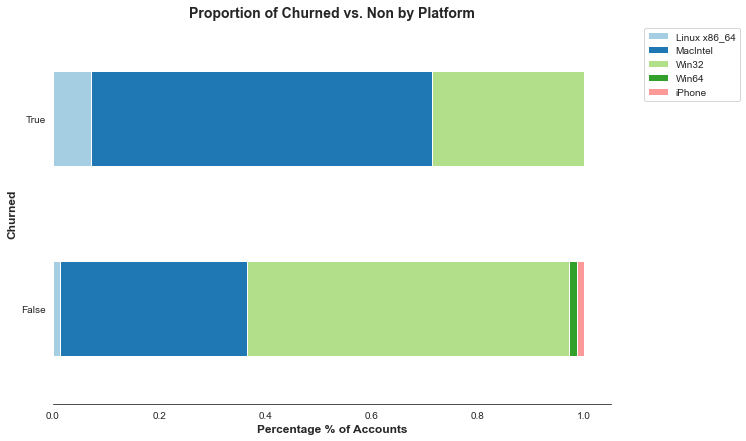

In [21]:
# look at use by platform / OS
df_platform = df_both.groupby(['device_platform', 'churned'], as_index=False)['company_name'].nunique()
df_platform['total'] = df_platform.groupby(['churned']).transform('sum')['company_name']
df_platform['tot_total'] =  df_platform.groupby(['device_platform']).transform('sum')['company_name']
df_platform['pct_of_class'] = df_platform['company_name']/df_platform['total']
df_platform['pct_total'] = df_platform['company_name']/df_platform['tot_total']
df_platform.sort_values(by=['device_platform', 'churned'])

df_long = df_platform[['churned', 'device_platform', 'pct_of_class']]
df_plot = (df_long.pivot(index=['churned'], 
                      columns=['device_platform'], 
                      values=['pct_of_class']))
df_plot.columns = list(df_plot.columns.get_level_values('device_platform'))
df_plot = df_plot.fillna(0)
df_plot = df_plot.reset_index()

sns.set_style('white')
sns.set_palette("Paired")
plt.close("all")
df_plot.plot( 
    x = 'churned', 
    kind = 'barh', 
    stacked = True, 
    figsize=(10,7)) 
plt.title(f"Proportion of Churned vs. Non by Platform", fontsize = 14, fontweight = 'semibold')
plt.xlabel("Percentage % of Accounts", fontsize = 12, fontweight = 'semibold')
plt.ylabel("Churned", fontsize = 12, fontweight = 'semibold')
plt.legend(bbox_to_anchor=(1.05, 1))
sns.despine(left = True)
plt.show()

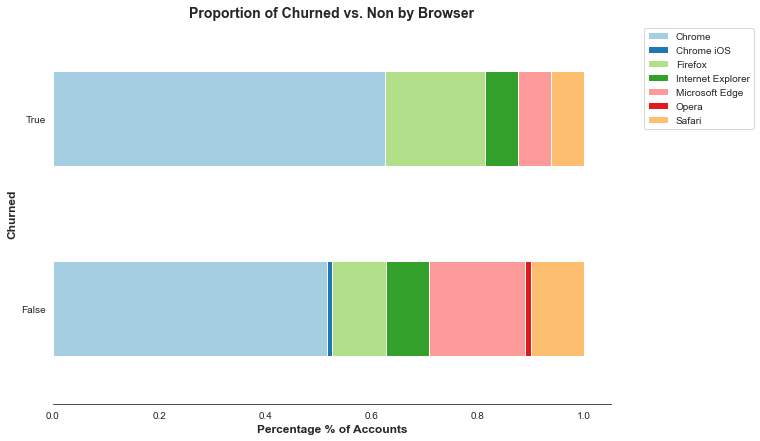

In [22]:
# look at use by browser
df_browser = df_both.groupby(['browser', 'churned'], as_index=False)['company_name'].nunique()
df_browser['total'] = df_browser.groupby(['churned']).transform('sum')['company_name']
df_browser['tot_total'] =  df_browser.groupby(['churned']).transform('sum')['company_name']
df_browser['pct_total'] = df_browser['company_name']/df_browser['total']
df_browser['pct_of_class'] = df_browser['company_name']/df_browser['tot_total']

df_long = df_browser[['churned', 'browser', 'pct_of_class']]
df_plot = (df_long.pivot(index=['churned'], 
                      columns=['browser'], 
                      values=['pct_of_class']))
df_plot.columns = list(df_plot.columns.get_level_values('browser'))
df_plot = df_plot.fillna(0)
df_plot = df_plot.reset_index()

sns.set_style('white')
sns.set_palette("Paired")
plt.close("all")
df_plot.plot( 
    x = 'churned', 
    kind = 'barh', 
    stacked = True, 
    figsize=(10,7)) 
plt.title(f"Proportion of Churned vs. Non by Browser", fontsize = 14, fontweight = 'semibold')
plt.xlabel("Percentage % of Accounts", fontsize = 12, fontweight = 'semibold')
plt.ylabel("Churned", fontsize = 12, fontweight = 'semibold')
plt.legend(bbox_to_anchor=(1.05, 1))
sns.despine(left = True)
plt.show()

In [23]:
# aggregate browser and platform to each account based on majority use
browsers = df_both.groupby(['company_name', 'browser']).agg(
    n_requests=pd.NamedAgg(column='request_id', aggfunc='count')).reset_index()
browsers['rank'] = browsers.groupby(['company_name'])['n_requests'].rank(ascending=False)
browsers = browsers[browsers['rank']==1].reset_index(drop=True).drop(['n_requests', 'rank'], axis=1)

platforms = df_both.groupby(['company_name', 'device_platform']).agg(
    n_requests=pd.NamedAgg(column='request_id', aggfunc='count')).reset_index()
platforms['rank'] = platforms.groupby(['company_name'])['n_requests'].rank(ascending=False)
platforms = platforms[platforms['rank']==1].reset_index(drop=True).drop(['n_requests', 'rank'], axis=1)

In [24]:
# let's see if we can predict churn with a random forest
df_forest = df_acct_agg.copy()
df_forest = df_forest.merge(platforms, on='company_name', how='left')
df_forest = df_forest.merge(browsers, on='company_name', how='left')
df_forest = df_forest.drop('account_id', axis=1) # we can just use company name
df_forest = pd.get_dummies(data=df_forest, columns=['device_platform', 'browser'])
df_forest['churned'] = np.where(df_forest['churned'] == True, 1, 0)
df_forest.tail()

company_name  churned  n_users  n_requests  n_use_days  n_docs  \
65            O'Keefe Ltd        0        1          31           1      15   
66       Duck & Bird, Inc        1        0           0           0       0   
67      Acme Dog Products        1        0           0           0       0   
68            MeWelco LLC        0        0           0           0       0   
69  Widget Stuff & Things        1        0           0           0       0   

    words_changed  min_words  max_words  max_edits  med_edits  \
65         2831.0        0.0      274.0        4.0        2.0   
66            0.0        0.0        0.0        0.0        0.0   
67            0.0        0.0        0.0        0.0        0.0   
68            0.0        0.0        0.0        0.0        0.0   
69            0.0        0.0        0.0        0.0        0.0   

    med_title_words  new_docs  docs_per_user  docs_per_day  requests_per_user  \
65              7.0         9           15.0          15.0               31.0   
66              0.0         0            0.0           0.0                0.0   
67              0.0         0            0.0           0.0                0.0   
68              0.0         0            0.0           0.0                0.0   
69              0.0         0            0.0           0.0                0.0   

    device_platform_MacIntel  device_platform_Win32  browser_Chrome  \
65                         1                      0               1   
66                         0                      0               0   
67                         0                      0               0   
68                         0                      0               0   
69                         0                      0               0   

    browser_Internet Explorer  browser_Microsoft Edge  browser_Safari  
65                          0                       0               0  
66                          0                       0               0  
67                          0                       0               0  
68                          0                       0               0  
69                          0                       0               0

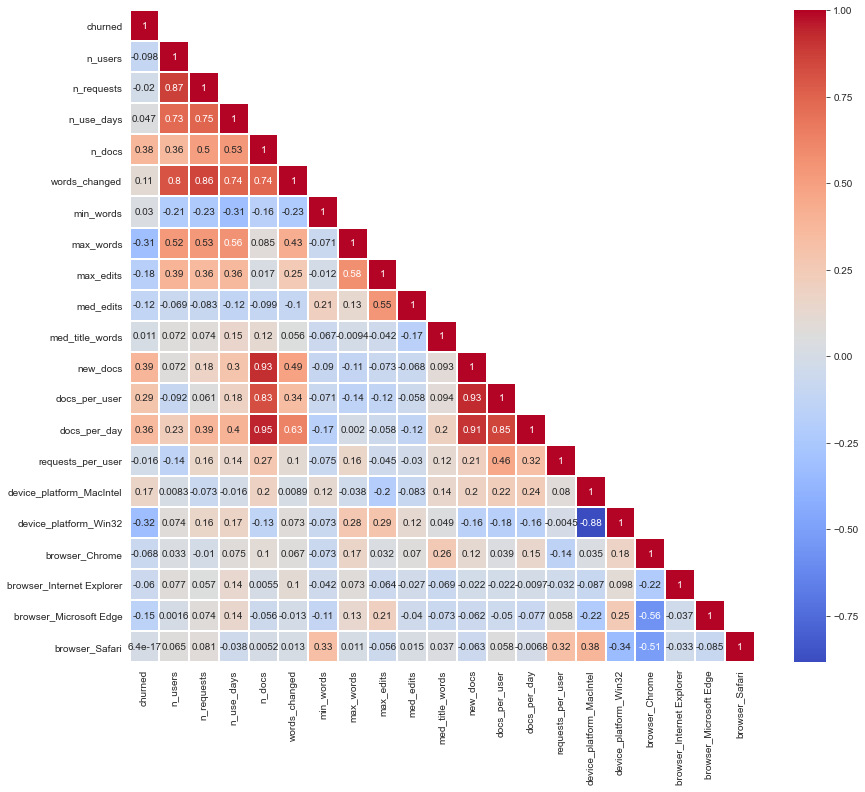

In [25]:
# let's look at highly correlated features
num_cols_2 = df_forest.select_dtypes(include=np.number).columns.tolist()
df_matrix = df_forest[num_cols_2]
corr = df_matrix.corr(method='pearson')

sns.set_style('white')
plt.figure(figsize = (14, 12))

# only lower half of matrix
df_lt = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))
sns.heatmap(df_lt, cmap="coolwarm", linecolor="white", linewidths=1, annot=True)
plt.show()

In [26]:
# see if data is imbalanced (it is)
df_forest['churned'].value_counts()

0    56
1    14
Name: churned, dtype: int64

In [27]:
def plot_conf_matrix(y_true, y_pred, name):
    '''
    function to plot a confusion matrix
    '''
    conf_mat = confusion_matrix(y_true, y_pred)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    conf_mat.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         conf_mat.flatten()/np.sum(conf_mat)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(9, 7))
    sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues', square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(f"Confusion Matrix for {name}", size=13, fontweight='semibold')
    plt.show()
    print(f"Accuracy score is: {np.round(accuracy_score(y_true, y_pred)*100.00, 2)}%")
    
def plot_feature_imp(model_name, x_class_name, plot_title_name="Feature Importance", n=20):
    '''
    function to feature importance
    '''
    columns = x_class_name.columns
    feat_imp = pd.DataFrame()
    feat_imp['scores'] = model_name.feature_importances_
    feat_imp['features'] = pd.Series(columns)
    plt.figure(figsize=(12, 5))
    ax = sns.barplot(
        data=feat_imp.sort_values(by='scores', ascending=False)[:n]
        , x='features', y='scores', palette='Blues_r'
                    )
    plt.title(f"{plot_title_name}", size=13, fontweight='semibold')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30, horizontalalignment='right')    
    sns.despine(left=True)
    plt.show()

In [28]:
# oversample the smaller class 
df_classifer_balanced_all = df_forest[df_forest['churned'] == 0].reset_index(drop=True)
temp = df_forest[df_forest['churned'] == 1].sample(len(df_classifer_balanced_all), replace=True)
df_classifer_balanced_all = pd.concat([df_classifer_balanced_all, temp], axis=0).reset_index(drop=True)
df_classifer_balanced_all['churned'].value_counts()

0    56
1    56
Name: churned, dtype: int64

In [29]:
df_classifier = df_classifer_balanced_all.drop('company_name', axis=1)
train_class, test_class = train_test_split(df_classifier,
                                test_size = 0.2, 
                                random_state = 123,
                                shuffle=True
                               )

train_y_class = train_class['churned']
train_x_class = train_class.drop('churned', axis=1)

test_y_class = test_class['churned']
test_x_class = test_class.drop('churned', axis=1)

class_model = RandomForestClassifier(random_state = 123, class_weight='balanced', n_estimators=1000, max_depth=4)

# fit on training data
class_model.fit(train_x_class, train_y_class)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

Baseline accuracy score is: 50.0 %


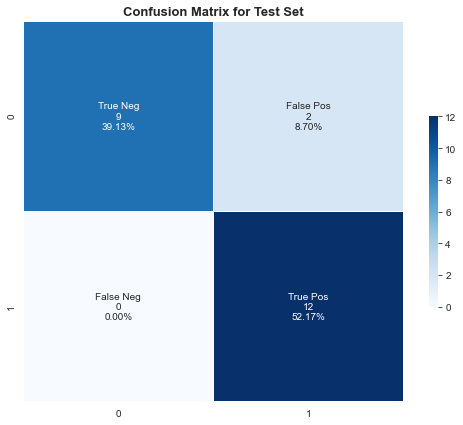

Accuracy score is: 91.3%


In [30]:
# What is baseline? 
print(f"Baseline accuracy score is: {np.round((len(df_classifier[df_classifier['churned'] == 0])/len(df_classifier))*100,2)} %")

y_pred = class_model.predict(test_x_class)  
plot_conf_matrix(y_true = test_y_class, y_pred = y_pred, name = "Test Set") 

In [31]:
# look at false positive(s)...
df_results = test_x_class.copy()
df_results['y_true'] = test_y_class
df_results['y_pred'] = y_pred
df_results[df_results['y_true'] != df_results['y_pred']]

n_users  n_requests  n_use_days  n_docs  words_changed  min_words  \
0        50        8421          26     401       158139.0        0.0   
29       10         773          23     110        50793.0        0.0   

    max_words  max_edits  med_edits  med_title_words  new_docs  docs_per_user  \
0      1421.0      387.0       26.0              4.0        89           8.02   
29     1059.0      104.0        5.0              3.0        30          11.00   

    docs_per_day  requests_per_user  device_platform_MacIntel  \
0      15.423077             168.42                         0   
29      4.782609              77.30                         1   

    device_platform_Win32  browser_Chrome  browser_Internet Explorer  \
0                       1               1                          0   
29                      0               1                          0   

    browser_Microsoft Edge  browser_Safari  y_true  y_pred  
0                        0               0       0       1  
29                       0               0       0       1

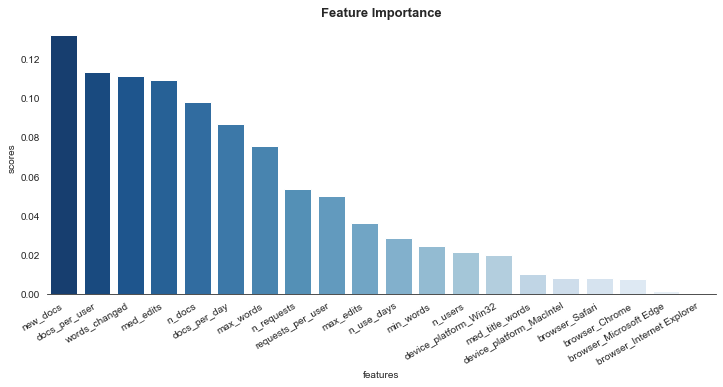

In [32]:
# feature importance scores for guidance (Gini index)
plot_feature_imp(model_name=class_model, x_class_name=test_x_class)

In [33]:
# curious how the model performs on only the accounts with events data
df_classifier_2 = df_forest[:66] # lazy way of removing those last 4 accounts with no activity

# oversample the smaller class 
df_classifer_balanced = df_classifier_2[df_classifier_2['churned'] == 0].reset_index(drop=True)
temp = df_classifier_2[df_classifier_2['churned'] == 1].sample(len(df_classifer_balanced), replace=True)
df_classifer_balanced = pd.concat([df_classifer_balanced, temp], axis=0).reset_index(drop=True)
df_classifer_balanced['churned'].value_counts()

0    55
1    55
Name: churned, dtype: int64

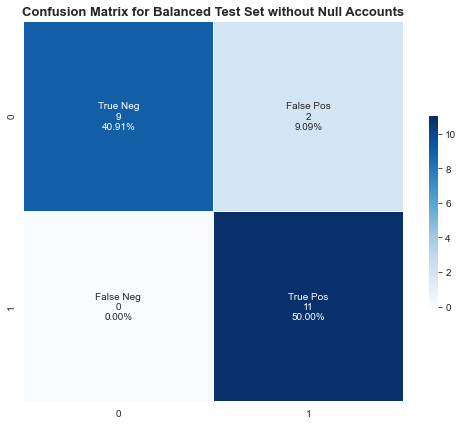

Accuracy score is: 90.91%


In [34]:
rf_classifer_balanced = df_classifer_balanced.drop('company_name', axis=1)
train_class, test_class = train_test_split(rf_classifer_balanced,
                                test_size = 0.2, 
                                random_state = 123,
                                shuffle=True
                               )

train_y_class = train_class['churned']
train_x_class = train_class.drop('churned', axis=1)

test_y_class = test_class['churned']
test_x_class = test_class.drop('churned', axis=1)

class_model_2 = RandomForestClassifier(random_state = 123, class_weight='balanced', n_estimators=1000, max_depth=4)

# fit on training data
class_model_2.fit(train_x_class, train_y_class)

y_pred = class_model_2.predict(test_x_class)  
plot_conf_matrix(y_true = test_y_class, y_pred = y_pred, name = "Balanced Test Set without Null Accounts") 

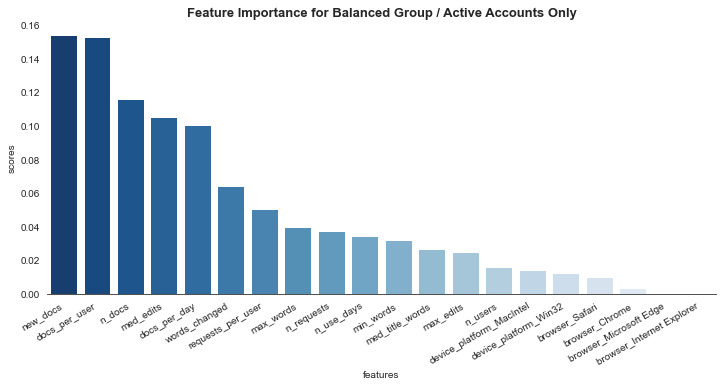

In [35]:
plot_feature_imp(model_name=class_model_2, x_class_name=test_x_class, plot_title_name='Feature Importance for Balanced Group / Active Accounts Only')

In [36]:
# look at top features from first model (actually performed slightly better) and revisit distributions
columns = test_x_class.columns
feat_imp = pd.DataFrame()
feat_imp['scores'] = class_model.feature_importances_
feat_imp['features'] = pd.Series(columns)
feat_imp = feat_imp.sort_values(by='scores', ascending=False).reset_index(drop=True)
feat_imp['cumulative scores'] = feat_imp['scores'].cumsum()
feat_80 = feat_imp[['features', 'scores', 'cumulative scores']][feat_imp['cumulative scores']<= .80] # almost 80% of model

all_feat = len(test_x_class.columns)
top_feat = len(feat_80)
print(f"{np.round(top_feat/all_feat, 2)*100.00}% of all features explain almost 80.0% of the model.")
print(feat_80)

40.0% of all features explain almost 80.0% of the model.
        features    scores  cumulative scores
0       new_docs  0.132330           0.132330
1  docs_per_user  0.113639           0.245969
2  words_changed  0.111404           0.357373
3      med_edits  0.109491           0.466863
4         n_docs  0.098125           0.564988
5   docs_per_day  0.087300           0.652287
6      max_words  0.075868           0.728156
7     n_requests  0.053704           0.781860


In [37]:
feature_names = ['Total NEW Docs'
                 , 'Mean Docs per User'
                 , 'Total Word Changes'
                 , 'Median Edits per Doc'
                 , 'Total Docs'
                 , 'Mean Docs per Day'
                 , 'Max Words in a Document'
                 , 'Mean Requests per User']
feat_80['feature name'] = feature_names
feat_80['scores'] = np.round(feat_80['scores'], 2)*100.00
feat_80['cumulative scores'] = np.round(feat_80['cumulative scores'], 2)*100.00
feat_80[['feature name', 'scores', 'cumulative scores']]

feature name  scores  cumulative scores
0           Total NEW Docs    13.0               13.0
1       Mean Docs per User    11.0               25.0
2       Total Word Changes    11.0               36.0
3     Median Edits per Doc    11.0               47.0
4               Total Docs    10.0               56.0
5        Mean Docs per Day     9.0               65.0
6  Max Words in a Document     8.0               73.0
7   Mean Requests per User     5.0               78.0

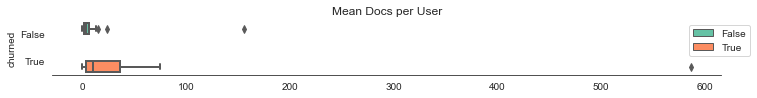

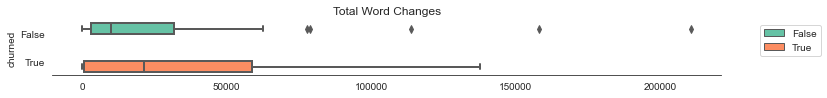

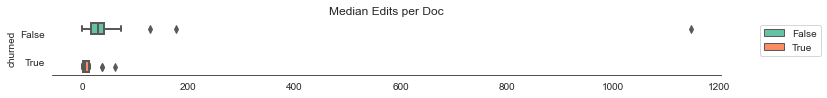

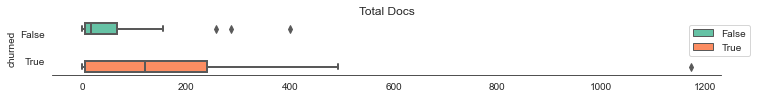

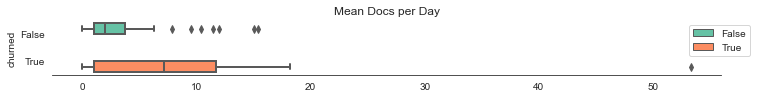

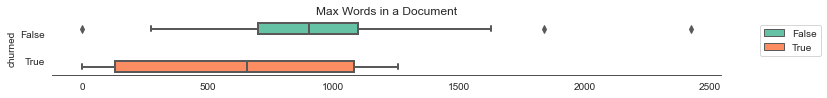

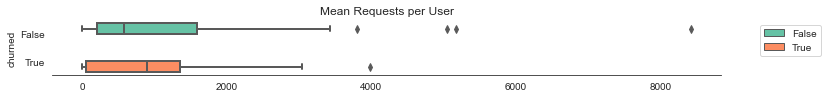

In [38]:
feature_cols = list(feat_80['features'])

for col, col_name in zip(feature_cols, feature_names):
    plt.figure(figsize=(12, 1))
    axes = sns.boxplot(data = df_acct_agg, x = f"{col}", y = 'churned'
                       , hue='churned', saturation=1, palette='Set2'
                       , linewidth=2, fliersize=5, orient='h')
    plt.ticklabel_format(style='plain', axis='x')
    plt.title(f"{col_name}")
    axes.set_xlabel('', fontsize = 12, fontweight = 'semibold')
    sns.despine(left = True)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

### Next Steps (time permitting): 
- SMOTE (Synthetic Minority Oversampling Technique) for better balancing of data
- Explore different strategies for outliers
- Run model on subsets of data (split by time); can I predict churn from 10 days in, 15, 20, etc? 
- More data exploration + segmentation around users and timestamps
    - Are there "Power Users?" 
- Possible segmentation by company/account
    - Matched cohorts model could also be useful
- Tune model with different time splits for training, tuning, and evaluating
- Productionalize model and run at a cadence that works for stakeholders and model performance. 

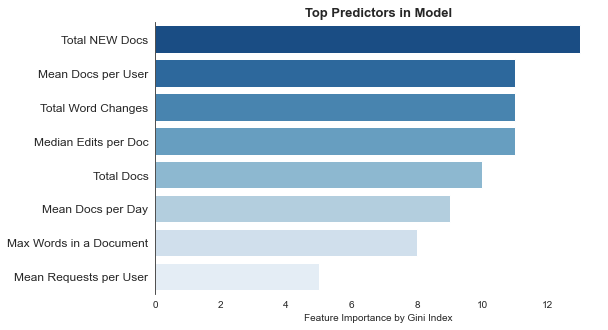

In [56]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=feat_80.sort_values(by='scores', ascending=False)
    , y='feature name', x='scores', palette='Blues_r'
                )
plt.title("Top Predictors in Model", size=13, fontweight='semibold')
# ax.set_yticklabels(ax.get_xticklabels(),rotation=30, horizontalalignment='right', size=12) 
ax.set_yticklabels(ax.get_yticklabels(), size=12) 
plt.xlabel("Feature Importance by Gini Index", size=10)
plt.ylabel("")
sns.despine(bottom=True)
plt.show()

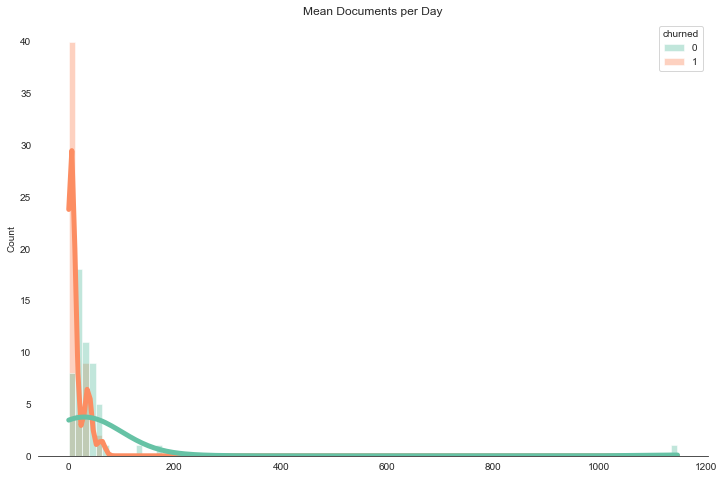

In [65]:
plt.figure(figsize=(12, 8))
axes = sns.histplot(data = df_classifer_balanced, x = 'med_edits'
                   , hue='churned',palette='Set2', kde=True
                   , alpha=.4, linewidth=.5, line_kws={'linewidth':5})
plt.ticklabel_format(style='plain', axis='x')
plt.title('Mean Documents per Day')
axes.set_xlabel('', fontsize = 12, fontweight = 'semibold')
sns.despine(left = True)
plt.show()